## install & import

In [38]:
#%pip install tensorflow==2.14.0

In [2]:
import math, pydot, graphviz
import numpy as np
import pandas as pd
from collections import defaultdict
# Split the data into train and test sets
# importing relevant libraries
from sklearn.model_selection import train_test_split
from book_funcs import *
import warnings
warnings.filterwarnings('ignore')
import requests
from PIL import Image
import matplotlib.pyplot as plt
import keras
#import pydot
import pydotplus
from pydotplus import graphviz
from keras.utils import plot_model
from keras.utils import model_to_dot
keras.utils.pydot = pydot
#plot_model(model)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from keras.regularizers import l2, l1
from keras import Input, Model
from keras.layers import SimpleRNN, Dense
from matplotlib import pyplot

## Import the file after PCA  and rearranging

In [6]:
df = pd.read_csv(r'C:\Users\yotam\Desktop\naya\df_clean_after_pca')
df = df[df['rating']!=0]
df_isbn = df['isbn']
num_dict = {}
for i,j in enumerate(df_isbn.unique()):
    num_dict[j]=i
df['isbn_num'] = df['isbn'].apply(lambda txt: num_dict[txt])
df = df.reset_index(drop = True)

In [7]:
df_cover = pd.read_csv(r'df_cover_pca.csv')


In [8]:
df = df.merge(df_cover, how='left', on='isbn', suffixes=(None, '_cover'))


In [26]:
df.head()

,Unnamed: 0,index,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,...,140_cover,141_cover,142_cover,143_cover,144_cover,145_cover,146_cover,147_cover,148_cover,149_cover
0,0,0,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,...,0.030522,-0.031867,-0.037713,0.006021,0.00409,-0.036732,-0.054969,0.012832,0.013244,-0.007381
1,0,0,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,...,0.030522,-0.031867,-0.037713,0.006021,0.00409,-0.036732,-0.054969,0.012832,0.013244,-0.007381
2,0,0,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,...,0.030522,-0.031867,-0.037713,0.006021,0.00409,-0.036732,-0.054969,0.012832,0.013244,-0.007381
3,0,0,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,...,0.030522,-0.031867,-0.037713,0.006021,0.00409,-0.036732,-0.054969,0.012832,0.013244,-0.007381
4,0,0,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,...,0.030522,-0.031867,-0.037713,0.006021,0.00409,-0.036732,-0.054969,0.012832,0.013244,-0.007381


In [9]:
book_author = df['book_author']
num_dict = {}
for i,j in enumerate(book_author.unique()):
    num_dict[j]=i
df['author_num'] = df['book_author'].apply(lambda txt: num_dict[txt])


## train test split

In [10]:
df =reader_encode(df)
#לשקול לעשות פה שאפל מוגדר
train_users, test_users = train_test_split(df, test_size = 0.2 , random_state= 42)
x_train = train_users.drop(columns=['rating'])
y_train = train_users["rating"]

x_test = test_users.drop(columns=['rating'])
y_test = test_users["rating"]
all_users = train_users["user_id"].unique()
all_books = train_users["isbn_num"].unique()
all_authors = train_users["author_num"].unique()
#df = pd.read_csv(r'/Users/royzalta/Downloads/archive/Books Data with Category Language and Summary/Preprocessed_data.csv')

## Implemation of TenserFlow

### naive model

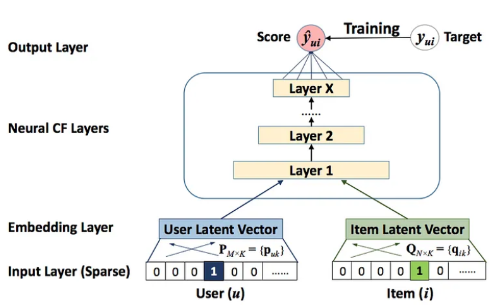

In [11]:
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32)(user_as_integer)
user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=1)(user_as_integer)

book_input = tf.keras.layers.Input(shape=(1,), name="book")
book_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_books)(book_input)
book_embedding = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=32)(book_as_integer)
book_bias = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=1)(book_as_integer)

dot = tf.keras.layers.Dot(axes=2)([user_embedding, book_embedding])
add = tf.keras.layers.Add()([dot, user_bias, book_bias])
flatten = tf.keras.layers.Flatten()(add)
squash = tf.keras.layers.Lambda(lambda x: 9 * tf.nn.sigmoid(x) + 1)(flatten)

model = tf.keras.Model(inputs=[user_input, book_input], outputs=squash)


model.compile(loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 book (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 integer_lookup (IntegerLoo  (None, 1)                    0         ['user[0][0]']                
 kup)                                                                                             
                                                                                                  
 integer_lookup_1 (IntegerL  (None, 1)                    0         ['book[0][0]']            

In [13]:
 model.fit(
     x={
         "user": x_train["user_id"],
         "book": x_train["isbn_num"]
     },
     y=y_train.values,
     batch_size=128,
     epochs=20,
     validation_split=0.1, # for early stopping
     callbacks=[
         tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
     ],
 )


Epoch 1/20
1558/1558 [==============================] - 20s 12ms/step - loss: 5.8798 - mean_absolute_error: 1.9228 - root_mean_squared_error: 2.4248 - val_loss: 5.2113 - val_mean_absolute_error: 1.7289 - val_root_mean_squared_error: 2.2828
Epoch 2/20
1558/1558 [==============================] - 18s 11ms/step - loss: 4.6866 - mean_absolute_error: 1.6188 - root_mean_squared_error: 2.1649 - val_loss: 4.5736 - val_mean_absolute_error: 1.5980 - val_root_mean_squared_error: 2.1386
Epoch 3/20
1558/1558 [==============================] - 18s 11ms/step - loss: 4.0901 - mean_absolute_error: 1.4899 - root_mean_squared_error: 2.0224 - val_loss: 4.1198 - val_mean_absolute_error: 1.4996 - val_root_mean_squared_error: 2.0297
Epoch 4/20
1558/1558 [==============================] - 18s 11ms/step - loss: 3.6283 - mean_absolute_error: 1.3826 - root_mean_squared_error: 1.9048 - val_loss: 3.7872 - val_mean_absolute_error: 1.4233 - val_root_mean_squared_error: 1.9461
Epoch 5/20
1558/1558 [==================

In [15]:
model.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"]#.reshape(-1, 1)
},y_test)

1732/1732 [==============================] - 3s 1ms/step - loss: 2.7265 - mean_absolute_error: 1.1462 - root_mean_squared_error: 1.6512


[2.7264626026153564, 1.1461507081985474, 1.651200294494629]

In [19]:
model.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"]#.reshape(-1, 1)
},y_test)

1293/1293 [==============================] - 3s 1ms/step - loss: 3.7359 - mean_absolute_error: 1.5488 - root_mean_squared_error: 1.9328


[3.7358641624450684, 1.5488183498382568, 1.9328383207321167]

### models with more inputs:

 ### model with emmbeding categories and summaries:

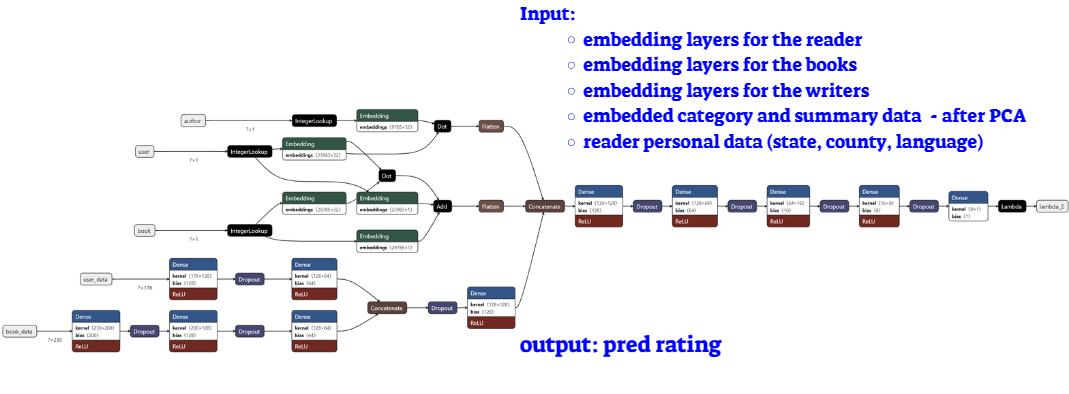

In [23]:
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32)(user_as_integer)
user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=1)(user_as_integer)

book_input = tf.keras.layers.Input(shape=(1,), name="book")
book_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_books)(book_input)
book_embedding = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=32)(book_as_integer)
book_bias = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=1)(book_as_integer)

feature_input = tf.keras.layers.Input(shape=(230,), name="user_book_data")
feature = tf.keras.layers.Dense(200, name="add_some_feature")(feature_input)
dropout1 = tf.keras.layers.Dropout(0.3, name="drop_some_feature")(feature)
feature2 = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature2")(dropout1)

dot = tf.keras.layers.Dot(axes=2)([user_embedding, book_embedding])
add = tf.keras.layers.Add()([dot, user_bias, book_bias])
flatten = tf.keras.layers.Flatten()(add)
con = tf.keras.layers.concatenate([flatten,feature2])
dense2 = tf.keras.layers.Dense(128, activation = 'relu', name="dence_layer2")(con)
dropout2 = tf.keras.layers.Dropout(0.3, name="drop_some_feature3")(dense2)
dense3 = tf.keras.layers.Dense(64, activation = 'relu', name="dence_layer3")(dropout2)
dropout3 = tf.keras.layers.Dropout(0.3, name="drop_some_feature4")(dense3)
dense4 = tf.keras.layers.Dense(16, activation = 'relu', name="dence_layer4")(dropout3)
dropout4 = tf.keras.layers.Dropout(0.3, name="drop_some_feature5")(dense4)
dense4= tf.keras.layers.Dense(1, activation = 'relu', name="dence_layer5")(dropout4) #addad 23/4/24 

squash = tf.keras.layers.Lambda(lambda x: 9 * tf.nn.sigmoid(x) + 1)(dense4)

model2 = tf.keras.Model(inputs=[user_input, book_input,feature_input], outputs=squash)

model2.compile(loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [24]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 book (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 integer_lookup_8 (IntegerL  (None, 1)                    0         ['user[0][0]']                
 ookup)                                                                                           
                                                                                                  
 integer_lookup_9 (IntegerL  (None, 1)                    0         ['book[0][0]']          

In [26]:
 model2.fit(
     x={
         "user": x_train["user_id"],
         "book": x_train["isbn_num"],
         "user_book_data":x_train[[str(i) for i in range(0,230)]]
     },
     y=y_train.values,
     batch_size=128,
     epochs=30,
     validation_split=0.1, # for early stopping
     callbacks=[
         tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
     ],
 )


Epoch 1/30
1558/1558 [==============================] - 20s 12ms/step - loss: 3.6290 - mean_absolute_error: 1.4835 - root_mean_squared_error: 1.9050 - val_loss: 3.3479 - val_mean_absolute_error: 1.3900 - val_root_mean_squared_error: 1.8297
Epoch 2/30
1558/1558 [==============================] - 23s 15ms/step - loss: 3.1259 - mean_absolute_error: 1.3214 - root_mean_squared_error: 1.7680 - val_loss: 3.2549 - val_mean_absolute_error: 1.3481 - val_root_mean_squared_error: 1.8041
Epoch 3/30
1558/1558 [==============================] - 22s 14ms/step - loss: 2.8071 - mean_absolute_error: 1.2076 - root_mean_squared_error: 1.6754 - val_loss: 3.2750 - val_mean_absolute_error: 1.3362 - val_root_mean_squared_error: 1.8097
Epoch 4/30
1558/1558 [==============================] - 35s 22ms/step - loss: 2.4918 - mean_absolute_error: 1.0954 - root_mean_squared_error: 1.5786 - val_loss: 3.3807 - val_mean_absolute_error: 1.3570 - val_root_mean_squared_error: 1.8387
Epoch 5/30
1558/1558 [==================

In [69]:
model.save('deep_model_emmbeding.h5')

C:\Users\yotam\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
#23/4/24 trying to evaluate
model2.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "user_book_data":x_test[[str(i) for i in range(0,230)]]
},y_test)

1732/1732 [==============================] - 7s 3ms/step - loss: 3.1554 - mean_absolute_error: 1.3310 - root_mean_squared_error: 1.7764


[3.155439615249634, 1.331011414527893, 1.7763557434082031]

In [36]:
model.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "user_book_data":x_test[[str(i) for i in range(0,230)]]
},y_test)

1293/1293 [==============================] - 3s 2ms/step - loss: 3.0212 - mean_absolute_error: 1.4065 - root_mean_squared_error: 1.7382


[3.021188497543335, 1.4065338373184204, 1.7381566762924194]

In [31]:
pred = model.predict({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "user_book_data":x_test[[str(i) for i in range(0,230)]]
})


1732/1732 [==============================] - 3s 2ms/step


In [30]:
minp = 99
maxp =0
for i in range(len(pred)):
    for j in range(len(pred[i])):
        minp = min(minp,pred[i][j])
        maxp = max(maxp,pred[i][j])
print(minp,",",maxp)
#מוזר, בריצה בעבר זה היה בין 5.5 ל 9, עכשיו זה טווח הרבה יותר קטן

5.5 , 5.886648


### Adding country and language as inputs

In [8]:
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32)(user_as_integer)
user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=1)(user_as_integer)

book_input = tf.keras.layers.Input(shape=(1,), name="book")
book_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_books)(book_input)
book_embedding = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=32)(book_as_integer)
book_bias = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=1)(book_as_integer)

feature_input = tf.keras.layers.Input(shape=(230,), name="book_data")
feature = tf.keras.layers.Dense(200, name="add_some_feature")(feature_input)
dropout1 = tf.keras.layers.Dropout(0.3, name="drop_some_feature")(feature)
feature2 = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature2")(dropout1)

user_feature_input = tf.keras.layers.Input(shape=(176,), name="user_data")
feature_u = tf.keras.layers.Dense(128, name="add_some_feature_u")(user_feature_input)
dropout1_u = tf.keras.layers.Dropout(0.4, name="drop_some_feature_u")(feature_u)
feature2_u = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature2_u")(dropout1_u)


dot = tf.keras.layers.Dot(axes=2)([user_embedding, book_embedding])
add = tf.keras.layers.Add()([dot, user_bias, book_bias])
flatten = tf.keras.layers.Flatten()(add)
con_book_users = tf.keras.layers.concatenate([feature2,feature2_u])
feature2_u = tf.keras.layers.Dense(128, activation = 'relu', name="reader_book_type")(con_book_users)

con = tf.keras.layers.concatenate([flatten,feature2_u])#,feature2_u])
dense2 = tf.keras.layers.Dense(128, activation = 'relu', name="dence_layer2")(con)
dropout2 = tf.keras.layers.Dropout(0.3, name="drop_some_feature3")(dense2)
dense3 = tf.keras.layers.Dense(64, activation = 'relu', name="dence_layer3")(dropout2)
dropout3 = tf.keras.layers.Dropout(0.3, name="drop_some_feature4")(dense3)
dense4 = tf.keras.layers.Dense(16, activation = 'relu', name="dence_layer4")(dropout3)
dropout4 = tf.keras.layers.Dropout(0.3, name="drop_some_feature5")(dense4)

squash = tf.keras.layers.Lambda(lambda x: 9 * tf.nn.sigmoid(x) + 1)(dropout4)

model = tf.keras.Model(inputs=[user_input, book_input,feature_input,user_feature_input], outputs=squash)

model.compile(loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])


In [10]:
 model.fit(
     x={
         "user": x_train["user_id"],
         "book": x_train["isbn_num"],
         "book_data":x_train[[str(i) for i in range(0,230)]], #category and summary
         'user_data':x_train[list(x_train.columns)[251:]]#+['age','year_of_publication']] #
     },
     y=y_train.values,
     batch_size=128,
     epochs=100,
     validation_split=0.1, # for early stopping
     shuffle= True,

     callbacks=[
         tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
     ],
 )


Epoch 1/100
1164/1164 [==============================] - 39s 13ms/step - loss: 4.7049 - mean_absolute_error: 1.7581 - root_mean_squared_error: 2.1691 - val_loss: 3.3110 - val_mean_absolute_error: 1.5026 - val_root_mean_squared_error: 1.8196
Epoch 2/100
1164/1164 [==============================] - 14s 12ms/step - loss: 4.3721 - mean_absolute_error: 1.6581 - root_mean_squared_error: 2.0910 - val_loss: 3.2330 - val_mean_absolute_error: 1.4823 - val_root_mean_squared_error: 1.7981
Epoch 3/100
1164/1164 [==============================] - 14s 12ms/step - loss: 4.0666 - mean_absolute_error: 1.5550 - root_mean_squared_error: 2.0166 - val_loss: 3.0286 - val_mean_absolute_error: 1.4104 - val_root_mean_squared_error: 1.7403
Epoch 4/100
1164/1164 [==============================] - 14s 12ms/step - loss: 3.7651 - mean_absolute_error: 1.4494 - root_mean_squared_error: 1.9404 - val_loss: 3.0216 - val_mean_absolute_error: 1.3899 - val_root_mean_squared_error: 1.7383
Epoch 5/100
1164/1164 [=============

KeyboardInterrupt: 

In [27]:
model.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "book_data":x_test[[str(i) for i in range(0,230)]],
    'user_data':x_test[list(x_train.columns)[251:]]
},y_test)
model.save('deep_model_emmbeding_finel.h5')


1293/1293 [==============================] - 3s 2ms/step - loss: 3.0826 - mean_absolute_error: 1.4157 - root_mean_squared_error: 1.7557


[3.082643747329712, 1.4157321453094482, 1.7557458877563477]

### adding L2 regularizetion

In [9]:
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32)(user_as_integer)
user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=1)(user_as_integer)

book_input = tf.keras.layers.Input(shape=(1,), name="book")
book_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_books)(book_input)
book_embedding = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=32)(book_as_integer)
book_bias = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=1)(book_as_integer)

author_input = tf.keras.layers.Input(shape=(1,), name="author")
author_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_authors)(author_input)
author_embedding = tf.keras.layers.Embedding(input_dim=len(all_authors) + 1, output_dim=32)(author_as_integer)

dot_author = tf.keras.layers.Dot(axes=2)([user_embedding, author_embedding])
flatten_author = tf.keras.layers.Flatten()(dot_author)

feature_input = tf.keras.layers.Input(shape=(230,), name="book_data")
feature = tf.keras.layers.Dense(200, activation = 'relu', name="add_some_feature",kernel_regularizer=l2(0.01))(feature_input)
dropout1 = tf.keras.layers.Dropout(0.2, name="drop_some_feature")(feature)
feature2 = tf.keras.layers.Dense(128, activation = 'relu', name="add_some_feature2",kernel_regularizer=l2(0.01))(dropout1)
dropout1_2 = tf.keras.layers.Dropout(0.2, name="drop_some_feature22")(feature2)
feature2_2 = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature22",kernel_regularizer=l2(0.01))(dropout1_2)

user_feature_input = tf.keras.layers.Input(shape=(176,), name="user_data")
feature_u = tf.keras.layers.Dense(128, activation = 'relu', name="add_some_feature_u",kernel_regularizer=l2(0.01))(user_feature_input)
dropout1_u = tf.keras.layers.Dropout(0.3, name="drop_some_feature_u2")(feature_u)
feature2_u = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature2_u2",kernel_regularizer=l2(0.01))(dropout1_u)

dot = tf.keras.layers.Dot(axes=2)([user_embedding, book_embedding])
add = tf.keras.layers.Add()([dot, user_bias, book_bias])
flatten = tf.keras.layers.Flatten()(add)
con_book_users = tf.keras.layers.concatenate([feature2_2,feature2_u])
dropout_after_con = tf.keras.layers.Dropout(0.2, name="dropout_after_con")(con_book_users)

feature2_u = tf.keras.layers.Dense(128, activation = 'relu', name="reader_book_type")(dropout_after_con)

con = tf.keras.layers.concatenate([flatten,flatten_author,feature2_u])#,feature2_u])
dense2 = tf.keras.layers.Dense(128, activation = 'relu', name="dence_layer2",kernel_regularizer=l2(0.01))(con)
dropout2 = tf.keras.layers.Dropout(0.2, name="drop_some_feature3")(dense2)
dense3 = tf.keras.layers.Dense(64, activation = 'relu', name="dence_layer3",kernel_regularizer=l2(0.01))(dropout2)
dropout3 = tf.keras.layers.Dropout(0.2, name="drop_some_feature4")(dense3)
dense4 = tf.keras.layers.Dense(16, activation = 'relu', name="dence_layer4",kernel_regularizer=l2(0.01))(dropout3)
dropout4 = tf.keras.layers.Dropout(0.2, name="drop_some_feature5")(dense4)
dense5 = tf.keras.layers.Dense(8, activation = 'relu', name="dence_layer5",kernel_regularizer=l2(0.01))(dropout4)
dropout5 = tf.keras.layers.Dropout(0.2, name="drop_some_feature6")(dense5)
dense6 = tf.keras.layers.Dense(1, name="dence_layer7")(dropout5)

squash = tf.keras.layers.Lambda(lambda x: 9 * tf.nn.sigmoid(x) + 1)(dense6)

model = tf.keras.Model(inputs=[user_input, book_input,author_input,feature_input,user_feature_input], outputs=squash)

model.compile(loss="mse",optimizer = 'adam', metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 book_data (InputLayer)      [(None, 230)]                0         []                            
                                                                                                  
 add_some_feature (Dense)    (None, 200)                  46200     ['book_data[0][0]']           
                                                                                                  
 drop_some_feature (Dropout  (None, 200)                  0         ['add_some_feature[0][0]']    
 )                                                                                                
                                                                                                  
 user_data (InputLayer)      [(None, 176)]                0         []                        

 dence_layer3 (Dense)        (None, 64)                   8256      ['drop_some_feature3[0][0]']  
                                                                                                  
 drop_some_feature4 (Dropou  (None, 64)                   0         ['dence_layer3[0][0]']        
 t)                                                                                               
                                                                                                  
 dence_layer4 (Dense)        (None, 16)                   1040      ['drop_some_feature4[0][0]']  
                                                                                                  
 drop_some_feature5 (Dropou  (None, 16)                   0         ['dence_layer4[0][0]']        
 t)                                                                                               
                                                                                                  
 dence_lay

In [20]:
 history=model.fit(
     x={
         "user": x_train["user_id"],
         "book": x_train["isbn_num"],
         "author":x_train['author_num'],
         "book_data":x_train[[str(i) for i in range(0,230)]], #category and summary
         'user_data':x_train[list(x_train.columns)[251:]]#+['age','year_of_publication']] #
     },
     y=y_train.values,
     batch_size=128,
     epochs=100,
     validation_split=0.15, # for early stopping
     shuffle= True,
     callbacks=[
         tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
     ],
 )

Epoch 1/100
1099/1099 [==============================] - 52s 40ms/step - loss: 4.1169 - mean_absolute_error: 1.4444 - root_mean_squared_error: 1.8103 - val_loss: 2.8703 - val_mean_absolute_error: 1.2923 - val_root_mean_squared_error: 1.6498
Epoch 2/100
1099/1099 [==============================] - 43s 39ms/step - loss: 1.9993 - mean_absolute_error: 1.0321 - root_mean_squared_error: 1.3581 - val_loss: 2.9198 - val_mean_absolute_error: 1.2875 - val_root_mean_squared_error: 1.6711
Epoch 3/100
1099/1099 [==============================] - 43s 39ms/step - loss: 1.2595 - mean_absolute_error: 0.7954 - root_mean_squared_error: 1.0637 - val_loss: 2.9466 - val_mean_absolute_error: 1.2960 - val_root_mean_squared_error: 1.6810
Epoch 4/100
1099/1099 [==============================] - 41s 38ms/step - loss: 1.0228 - mean_absolute_error: 0.7008 - root_mean_squared_error: 0.9515 - val_loss: 2.9505 - val_mean_absolute_error: 1.2879 - val_root_mean_squared_error: 1.6846
Epoch 5/100
1099/1099 [=============

### results with diffrent level of dropout:

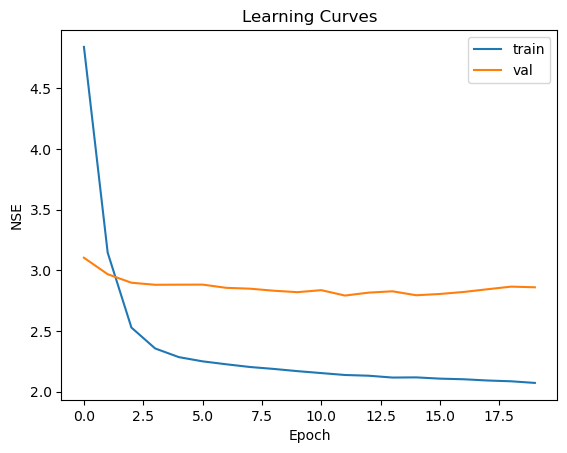

In [27]:
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

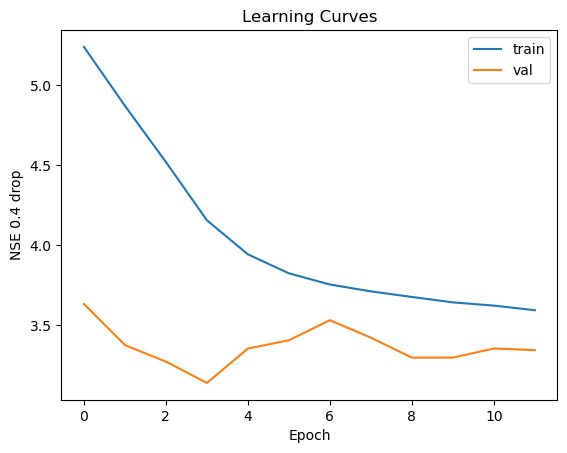

In [24]:
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('NSE 0.4 drop')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### with dropout 0.3

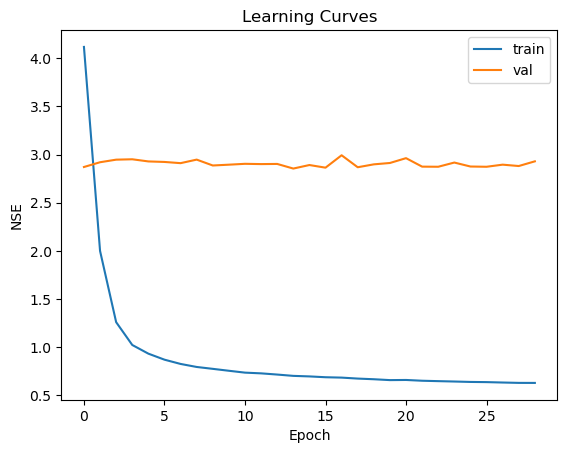

In [25]:
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('NSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### with dropout 0.2

In [13]:
model.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "author":x_test['author_num'],
    "book_data":x_test[[str(i) for i in range(0,230)]],
    'user_data':x_test[list(x_train.columns)[251:]]
},y_test)

1293/1293 [==============================] - 57s 43ms/step - loss: 2.8798 - mean_absolute_error: 1.2806 - root_mean_squared_error: 1.6805


[2.879767417907715, 1.2805535793304443, 1.6805320978164673]

#### finel results: loss,mean_absolute_error and root_mean_squared_error 

with 0.2 drop rates:[2.879767417907715, 1.2805535793304443, 1.6805320978164673]

with 0.3 drop rates: [3.1028785705566406, 1.4370495080947876, 1.7614989280700684]

with 0.5 drop rates:[3.4600727558135986, 1.49246346950531, 1.8601270914077759]

In [22]:
model.save('deep_model_emmbeding_author.h5')


In [12]:
pred = model.predict({
            "user": df_books["user_id"],#.reshape(-1, 1), # fill user 1 in many times
            "book": df_books["isbn_num"],#.reshape(-1, 1),
            "author":df_books['author_num'],
            "book_data":df_books[[str(i) for i in range(0,230)]],
            'user_data':df_books[list(x_train.columns)[251:]]})


NameError: name 'df_books' is not defined

In [11]:
from keras.models import load_model
model = load_model('deep_model_emmbeding_author.h5')

In [14]:
pred = model.predict({
                "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
                "book": x_test["isbn_num"],#.reshape(-1, 1),
                "author":x_test['author_num'],
                "book_data":x_test[[str(i) for i in range(0,230)]],
                'user_data':x_test[list(x_train.columns)[251:]]})



1293/1293 [==============================] - 60s 46ms/step


###  Finally adding the book covers

In [32]:
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32)(user_as_integer)
user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=1)(user_as_integer)

book_input = tf.keras.layers.Input(shape=(1,), name="book")
book_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_books)(book_input)
book_embedding = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=32)(book_as_integer)
book_bias = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=1)(book_as_integer)

author_input = tf.keras.layers.Input(shape=(1,), name="author")
author_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_authors)(author_input)
author_embedding = tf.keras.layers.Embedding(input_dim=len(all_authors) + 1, output_dim=32)(author_as_integer)

dot_author = tf.keras.layers.Dot(axes=2)([user_embedding, author_embedding])
flatten_author = tf.keras.layers.Flatten()(dot_author)


feature_input = tf.keras.layers.Input(shape=(230,), name="book_data")
feature = tf.keras.layers.Dense(200, activation = 'relu', name="add_some_feature",kernel_regularizer=l2(0.01))(feature_input)
dropout1 = tf.keras.layers.Dropout(0.2, name="drop_some_feature")(feature)
feature2 = tf.keras.layers.Dense(128, activation = 'relu', name="add_some_feature2",kernel_regularizer=l2(0.01))(dropout1)
dropout1_2 = tf.keras.layers.Dropout(0.2, name="drop_some_feature22")(feature2)
book_feature2_2 = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature22",kernel_regularizer=l2(0.01))(dropout1_2)

#cover data
cover_input = tf.keras.layers.Input(shape=(150,), name="book_cover_data")
cover_feature = tf.keras.layers.Dense(128, activation = 'relu', name="cover_add_some_feature",kernel_regularizer=l2(0.01))(cover_input)
cover_dropout1 = tf.keras.layers.Dropout(0.2, name="cover_drop_some_feature")(cover_feature)
cover_feature2 = tf.keras.layers.Dense(64, activation = 'relu', name="cover_add_some_feature2",kernel_regularizer=l2(0.01))(cover_dropout1)
cover_dropout1_2 = tf.keras.layers.Dropout(0.2, name="cover_drop_some_feature22")(cover_feature2)
cover_feature2_2 = tf.keras.layers.Dense(32, activation = 'relu', name="cover_add_some_feature22",kernel_regularizer=l2(0.01))(cover_dropout1_2)



user_feature_input = tf.keras.layers.Input(shape=(176,), name="user_data")
feature_u = tf.keras.layers.Dense(128, activation = 'relu', name="add_some_feature_u",kernel_regularizer=l2(0.01))(user_feature_input)
dropout1_u = tf.keras.layers.Dropout(0.3, name="drop_some_feature_u2")(feature_u)
user_feature2 = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature2_u2",kernel_regularizer=l2(0.01))(dropout1_u)


dot = tf.keras.layers.Dot(axes=2)([user_embedding, book_embedding])
add = tf.keras.layers.Add()([dot, user_bias, book_bias])
flatten = tf.keras.layers.Flatten()(add)

con_book_and_cover = tf.keras.layers.concatenate([book_feature2_2,cover_feature2_2])
cover_book_dropout = tf.keras.layers.Dropout(0.2, name="con_drop_some_feature22")(con_book_and_cover)
cover_book_marge_feature = tf.keras.layers.Dense(32, activation = 'relu', name="con_add_some_feature22",kernel_regularizer=l2(0.01))(cover_book_dropout)

con_book_users = tf.keras.layers.concatenate([cover_book_marge_feature,user_feature2])
dropout_after_con = tf.keras.layers.Dropout(0.2, name="dropout_after_con")(con_book_users)

feature2_u = tf.keras.layers.Dense(128, activation = 'relu', name="reader_book_type")(dropout_after_con)

con = tf.keras.layers.concatenate([flatten,flatten_author,feature2_u])#,feature2_u])
dense2 = tf.keras.layers.Dense(128, activation = 'relu', name="dence_layer2",kernel_regularizer=l2(0.01))(con)
dropout2 = tf.keras.layers.Dropout(0.2, name="drop_some_feature3")(dense2)
dense3 = tf.keras.layers.Dense(64, activation = 'relu', name="dence_layer3",kernel_regularizer=l2(0.01))(dropout2)
dropout3 = tf.keras.layers.Dropout(0.2, name="drop_some_feature4")(dense3)
dense4 = tf.keras.layers.Dense(16, activation = 'relu', name="dence_layer4",kernel_regularizer=l2(0.01))(dropout3)
dropout4 = tf.keras.layers.Dropout(0.2, name="drop_some_feature5")(dense4)
dense5 = tf.keras.layers.Dense(8, activation = 'relu', name="dence_layer5",kernel_regularizer=l2(0.01))(dropout4)
dropout5 = tf.keras.layers.Dropout(0.2, name="drop_some_feature6")(dense5)
dense6 = tf.keras.layers.Dense(1, name="dence_layer7")(dropout5)
#dropout6 = tf.keras.layers.Dropout(0.25, name="drop_some_feature7")(dense6)

squash = tf.keras.layers.Lambda(lambda x: 9 * tf.nn.sigmoid(x) + 1)(dense6)



model = tf.keras.Model(inputs=[user_input, book_input,author_input,feature_input,cover_input,user_feature_input], outputs=squash)


model.compile(loss="mse",optimizer = 'adam', metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])


NameError: name 'l2' is not defined

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 book_data (InputLayer)      [(None, 230)]                0         []                            
                                                                                                  
 book_cover_data (InputLaye  [(None, 150)]                0         []                            
 r)                                                                                               
                                                                                                  
 add_some_feature (Dense)    (None, 200)                  46200     ['book_data[0][0]']           
                                                                                                  
 cover_add_some_feature (De  (None, 128)                  19328     ['book_cover_data[0][0]'] 

 concatenate_1 (Concatenate  (None, 96)                   0         ['con_add_some_feature22[0][0]
 )                                                                  ',                            
                                                                     'add_some_feature2_u2[0][0]']
                                                                                                  
 add (Add)                   (None, 1, 1)                 0         ['dot_1[0][0]',               
                                                                     'embedding_1[0][0]',         
                                                                     'embedding_3[0][0]']         
                                                                                                  
 dot (Dot)                   (None, 1, 1)                 0         ['embedding[0][0]',           
                                                                     'embedding_4[0][0]']         
          

In [20]:
 history=model.fit(
     x={
         "user": x_train["user_id"],
         "book": x_train["isbn_num"],
         "author":x_train['author_num'],
         "book_data":x_train[[str(i) for i in range(0,230)]], #category and summary
         "book_cover_data":x_train[[col for col in x_train.columns if "cover" in col][1:]],
         'user_data':x_train[list(x_train.columns)[402:]]#+['age','year_of_publication']] #
     },
     y=y_train.values,
     batch_size=128,
     epochs=100,
     validation_split=0.15, # for early stopping
     shuffle= True,
     callbacks=[
         tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
     ],
 )
# לשקול לעשות פה שאפל מוגדר בוולידיישן, יש בעיה עם זה שלא עושים שאפל


Epoch 1/100
1472/1472 [==============================] - 71s 41ms/step - loss: 4.4426 - mean_absolute_error: 1.4858 - root_mean_squared_error: 1.9146 - val_loss: 2.8400 - val_mean_absolute_error: 1.2199 - val_root_mean_squared_error: 1.6489
Epoch 2/100
1472/1472 [==============================] - 59s 40ms/step - loss: 2.4291 - mean_absolute_error: 1.1259 - root_mean_squared_error: 1.5095 - val_loss: 2.8649 - val_mean_absolute_error: 1.2202 - val_root_mean_squared_error: 1.6527
Epoch 3/100
1472/1472 [==============================] - 58s 40ms/step - loss: 1.8124 - mean_absolute_error: 0.9609 - root_mean_squared_error: 1.2957 - val_loss: 2.8385 - val_mean_absolute_error: 1.2035 - val_root_mean_squared_error: 1.6472
Epoch 4/100
1472/1472 [==============================] - 58s 40ms/step - loss: 1.6271 - mean_absolute_error: 0.9016 - root_mean_squared_error: 1.2265 - val_loss: 2.8474 - val_mean_absolute_error: 1.2137 - val_root_mean_squared_error: 1.6525
Epoch 5/100
1472/1472 [=============

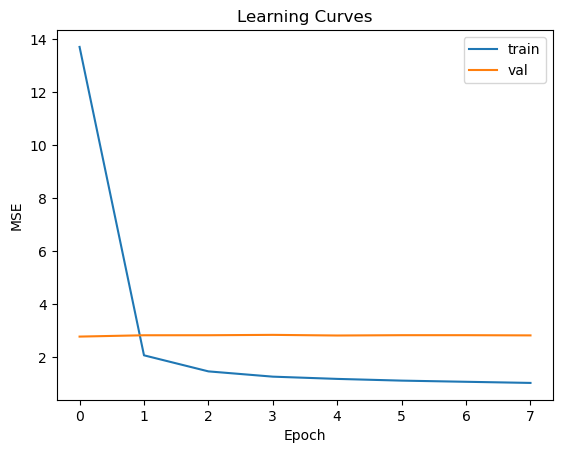

In [33]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()
plt.show()

In [22]:
model.save('finel_deep_model.h5')


In [23]:
model.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "author":x_test['author_num'],
    "book_data":x_test[[str(i) for i in range(0,230)]], #category and summary
    "book_cover_data":x_test[[col for col in x_train.columns if "cover" in col][1:]],
    'user_data':x_test[list(x_train.columns)[402:]]
},y_test)

1732/1732 [==============================] - 4s 2ms/step - loss: 2.5754 - mean_absolute_error: 1.1525 - root_mean_squared_error: 1.5863


[2.575368881225586, 1.1525238752365112, 1.586316704750061]

### using higher regularizetion rate with L1+L2

In [34]:
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32)(user_as_integer)
user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=1)(user_as_integer)

book_input = tf.keras.layers.Input(shape=(1,), name="book")
book_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_books)(book_input)
book_embedding = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=32)(book_as_integer)
book_bias = tf.keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=1)(book_as_integer)

author_input = tf.keras.layers.Input(shape=(1,), name="author")
author_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_authors)(author_input)
author_embedding = tf.keras.layers.Embedding(input_dim=len(all_authors) + 1, output_dim=32)(author_as_integer)

dot_author = tf.keras.layers.Dot(axes=2)([user_embedding, author_embedding])
flatten_author = tf.keras.layers.Flatten()(dot_author)


feature_input = tf.keras.layers.Input(shape=(230,), name="book_data")
feature = tf.keras.layers.Dense(200, activation = 'relu', name="add_some_feature",kernel_regularizer=l1(0.05))(feature_input)
dropout1 = tf.keras.layers.Dropout(0.2, name="drop_some_feature")(feature)
feature2 = tf.keras.layers.Dense(128, activation = 'relu', name="add_some_feature2",kernel_regularizer=l1(0.05))(dropout1)
dropout1_2 = tf.keras.layers.Dropout(0.2, name="drop_some_feature22")(feature2)
book_feature2_2 = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature22",kernel_regularizer=l1(0.05))(dropout1_2)

#cover data
cover_input = tf.keras.layers.Input(shape=(150,), name="book_cover_data")
cover_feature = tf.keras.layers.Dense(128, activation = 'relu', name="cover_add_some_feature",kernel_regularizer=l1(0.05))(cover_input)
cover_dropout1 = tf.keras.layers.Dropout(0.2, name="cover_drop_some_feature")(cover_feature)
cover_feature2 = tf.keras.layers.Dense(64, activation = 'relu', name="cover_add_some_feature2",kernel_regularizer=l1(0.05))(cover_dropout1)
cover_dropout1_2 = tf.keras.layers.Dropout(0.2, name="cover_drop_some_feature22")(cover_feature2)
cover_feature2_2 = tf.keras.layers.Dense(32, activation = 'relu', name="cover_add_some_feature22",kernel_regularizer=l1(0.05))(cover_dropout1_2)



user_feature_input = tf.keras.layers.Input(shape=(176,), name="user_data")
feature_u = tf.keras.layers.Dense(128, activation = 'relu', name="add_some_feature_u",kernel_regularizer=l2(0.02))(user_feature_input)
dropout1_u = tf.keras.layers.Dropout(0.3, name="drop_some_feature_u2")(feature_u)
user_feature2 = tf.keras.layers.Dense(64, activation = 'relu', name="add_some_feature2_u2",kernel_regularizer=l2(0.02))(dropout1_u)


dot = tf.keras.layers.Dot(axes=2)([user_embedding, book_embedding])
add = tf.keras.layers.Add()([dot, user_bias, book_bias])
flatten = tf.keras.layers.Flatten()(add)

con_book_and_cover = tf.keras.layers.concatenate([book_feature2_2,cover_feature2_2])
cover_book_dropout = tf.keras.layers.Dropout(0.2, name="con_drop_some_feature22")(con_book_and_cover)
cover_book_marge_feature = tf.keras.layers.Dense(32, activation = 'relu', name="con_add_some_feature22",kernel_regularizer=l2(0.01))(cover_book_dropout)

con_book_users = tf.keras.layers.concatenate([cover_book_marge_feature,user_feature2])
dropout_after_con = tf.keras.layers.Dropout(0.2, name="dropout_after_con")(con_book_users)

feature2_u = tf.keras.layers.Dense(128, activation = 'relu', name="reader_book_type")(dropout_after_con)

con = tf.keras.layers.concatenate([flatten,flatten_author,feature2_u])#,feature2_u])
dense2 = tf.keras.layers.Dense(128, activation = 'relu', name="dence_layer2",kernel_regularizer=l2(0.02))(con)
dropout2 = tf.keras.layers.Dropout(0.2, name="drop_some_feature3")(dense2)
dense3 = tf.keras.layers.Dense(64, activation = 'relu', name="dence_layer3",kernel_regularizer=l2(0.02))(dropout2)
dropout3 = tf.keras.layers.Dropout(0.2, name="drop_some_feature4")(dense3)
dense4 = tf.keras.layers.Dense(16, activation = 'relu', name="dence_layer4",kernel_regularizer=l2(0.02))(dropout3)
dropout4 = tf.keras.layers.Dropout(0.2, name="drop_some_feature5")(dense4)
dense5 = tf.keras.layers.Dense(8, activation = 'relu', name="dence_layer5",kernel_regularizer=l2(0.02))(dropout4)
dropout5 = tf.keras.layers.Dropout(0.2, name="drop_some_feature6")(dense5)
dense6 = tf.keras.layers.Dense(1, name="dence_layer7")(dropout5)
#dropout6 = tf.keras.layers.Dropout(0.25, name="drop_some_feature7")(dense6)

squash = tf.keras.layers.Lambda(lambda x: 9 * tf.nn.sigmoid(x) + 1)(dense6)



model2 = tf.keras.Model(inputs=[user_input, book_input,author_input,feature_input,cover_input,user_feature_input], outputs=squash)


model2.compile(loss="mse",optimizer = 'adam', metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])


In [35]:
 history2=model2.fit(
     x={
         "user": x_train["user_id"],
         "book": x_train["isbn_num"],
         "author":x_train['author_num'],
         "book_data":x_train[[str(i) for i in range(0,230)]], #category and summary
         "book_cover_data":x_train[[col for col in x_train.columns if "cover" in col][1:]],
         'user_data':x_train[list(x_train.columns)[402:]]#+['age','year_of_publication']] #
     },
     y=y_train.values,
     batch_size=128,
     epochs=100,
     validation_split=0.15, # for early stopping
     shuffle= True,
     callbacks=[
         tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
     ],
 )
# לשקול לעשות פה שאפל מוגדר בוולידיישן, יש בעיה עם זה שלא עושים שאפל


Epoch 1/100
1472/1472 [==============================] - 52s 33ms/step - loss: 17.3465 - mean_absolute_error: 1.4496 - root_mean_squared_error: 1.8753 - val_loss: 3.4530 - val_mean_absolute_error: 1.2032 - val_root_mean_squared_error: 1.6086
Epoch 2/100
1472/1472 [==============================] - 53s 36ms/step - loss: 2.9594 - mean_absolute_error: 1.0795 - root_mean_squared_error: 1.4347 - val_loss: 3.4837 - val_mean_absolute_error: 1.1717 - val_root_mean_squared_error: 1.6118
Epoch 3/100
1472/1472 [==============================] - 53s 36ms/step - loss: 2.2946 - mean_absolute_error: 0.8976 - root_mean_squared_error: 1.1916 - val_loss: 3.5105 - val_mean_absolute_error: 1.1719 - val_root_mean_squared_error: 1.6241
Epoch 4/100
1472/1472 [==============================] - 53s 36ms/step - loss: 2.0839 - mean_absolute_error: 0.8313 - root_mean_squared_error: 1.1055 - val_loss: 3.3636 - val_mean_absolute_error: 1.1654 - val_root_mean_squared_error: 1.5852
Epoch 5/100
1472/1472 [============

In [36]:
#23/4/24
model2.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "author":x_test['author_num'],
    "book_data":x_test[[str(i) for i in range(0,230)]], #category and summary
    "book_cover_data":x_test[[col for col in x_train.columns if "cover" in col][1:]],
    'user_data':x_test[list(x_train.columns)[402:]]
},y_test)

1732/1732 [==============================] - 4s 2ms/step - loss: 3.1388 - mean_absolute_error: 1.0907 - root_mean_squared_error: 1.5380


[3.138840436935425, 1.0907305479049683, 1.5379846096038818]

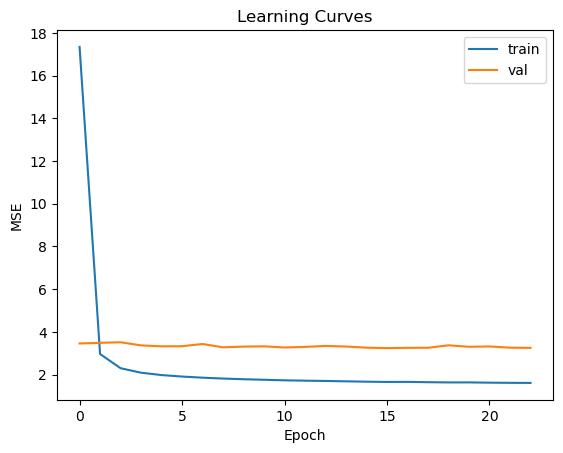

In [37]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()
plt.show()

In [30]:
model2.evaluate({
    "user": x_test["user_id"],#.reshape(-1, 1), # fill user 1 in many times
    "book": x_test["isbn_num"],#.reshape(-1, 1),
    "author":x_test['author_num'],
    "book_data":x_test[[str(i) for i in range(0,230)]], #category and summary
    "book_cover_data":x_test[[col for col in x_train.columns if "cover" in col][1:]],
    'user_data':x_test[list(x_train.columns)[402:]]
},y_test)

1732/1732 [==============================] - 5s 3ms/step - loss: 2.7101 - mean_absolute_error: 1.0174 - root_mean_squared_error: 1.4100


[2.710057258605957, 1.0174052715301514, 1.4100064039230347]

## example of the results:

6


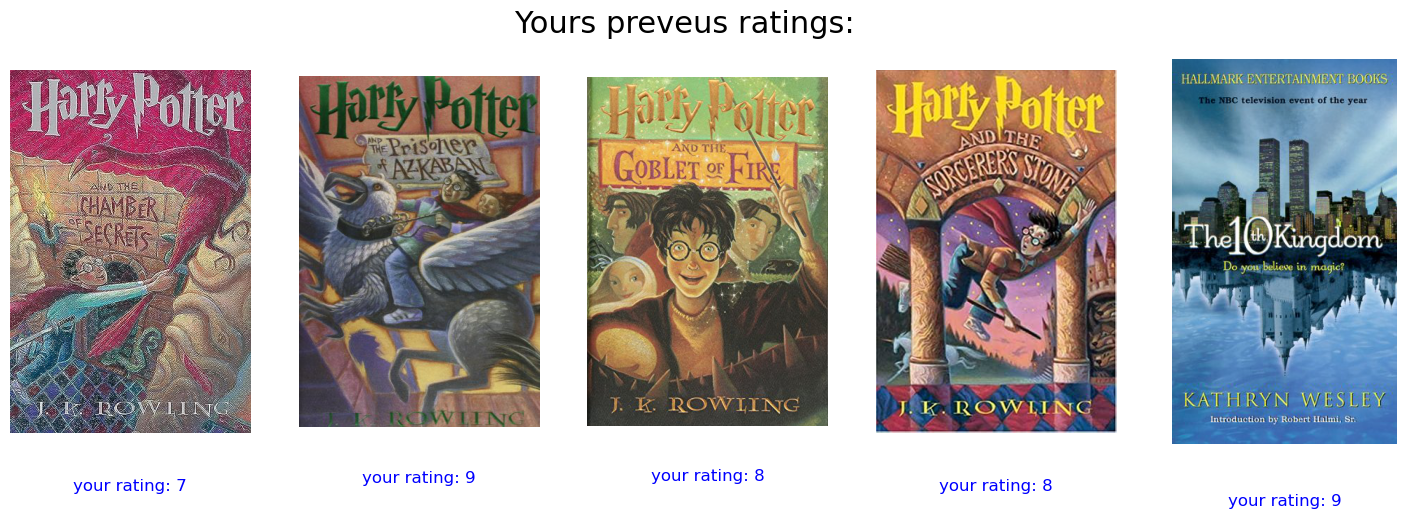

In [80]:
rated_books(df,4809)

967/967 [==============================] - 2s 2ms/step


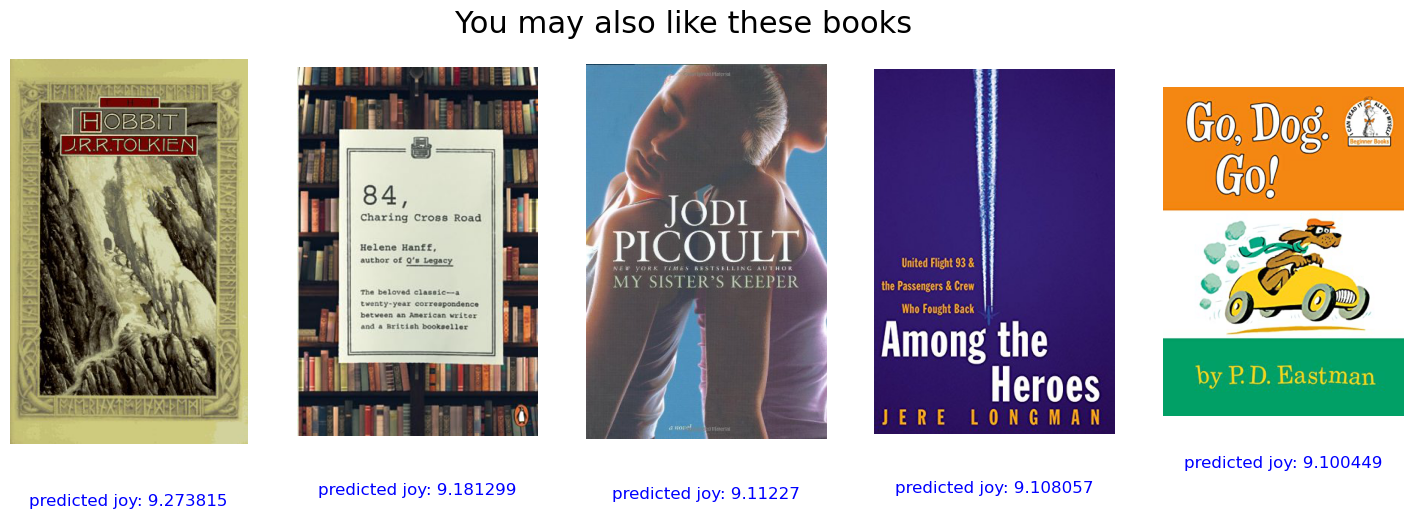

In [81]:
deep_recommender(df,4809)


It should be noted that there are no additional Harry Potter books in our database (except for 1-5 in different languages), therefore the system does not recommend the user to continue the series:

In [87]:
df[df['book_title'].str.contains('Harry Potter')]['book_title'].unique()


array(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       "Harry Potter and the Sorcerer's Stone (Book 1)",
       "The Sorcerer's Companion: A Guide to the Magical World of Harry Potter",
       "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
       'Harry Potter and the Chamber of Secrets (Book 2 Audio CD)',
       "Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)",
       'The Magical Worlds of Harry Potter: A Treasury of Myths, Legends, and Fascinating Facts',
       'Harry Potter y la piedra filosofal',
       'Harry Potter y la cÃ¡mara secreta',
       'Harry Potter y el prisionero de Azkaban',
       'Harry Potter y el cÃ¡liz de fuego',
       'Harry Potter Schoolbooks: Quidditch Through the Ages and Fantastic Beasts and Where to Find Them',
       'J. K. Rowling: The Wiz